# State Crash Data Preprocessing and EDA

## Aggregating Yearly State Crash Data 

**Raw Features (of interest)**
* Crash ID
* Crash Year
* Report State
* Crash Date
* Truck Bus Indicator
* Fatalities
* Injuries
* Vehicles In Accident
* City
* County Code
* County Name
* State

**Derived Features**
* Crash Year
* Crash Month
* State
* County Code
* crash_count
* total_fatalities
* total_injuries
* total_vehicles


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, month, year, avg, count
from pyspark.sql.types import StructType, StructField, StringType
import os
import pandas as pd
from functools import reduce
from pyspark.sql import DataFrame
import os
from pyspark.sql.functions import lit, col, to_date, month
from pyspark.sql.functions import col, count, sum, when, isnan, mean, corr, month, year, desc
from pyspark.sql.types import IntegerType, DoubleType, FloatType, DateType

In [0]:
spark = SparkSession.builder.appName("State Crash Data Preprocessing").getOrCreate()

In [0]:
data_path = "/FileStore/tables/yearly_state_crash_data"
all_dfs = []
for year in ["2023", "2024", "2025"]:
    file_path = f"{data_path}/state_crash_data_{year}.csv"
    df = spark.read.format("com.databricks.spark.csv").option("header", "true").load(file_path)
    all_dfs.append(df)

In [0]:
# Combine all dataframes if we found any
if all_dfs:
    # Union all dataframes
    all_data = reduce(DataFrame.unionByName, all_dfs)

In [0]:
# Convert date string to date type
all_data = all_data.withColumn("Crash Date", to_date(col("Crash Date"), "MM/dd/yyyy"))

# Create month and year columns for analysis
all_data = all_data.withColumn("Crash Month", month("Crash Date"))

# Ensure Crash Year is numeric
all_data = all_data.withColumn("Crash Year", col("Crash Year").cast("integer"))


all_data = all_data.select("Crash ID", "Crash Year", "Report State", "Crash Date", "Truck Bus Indicator", "Fatalities", "Injuries", "Vehicles In Accident",  "County Code", "County Name", "State")

In [0]:
all_data.cache()

DataFrame[Crash ID: string, Crash Year: int, Report State: string, Crash Date: date, Truck Bus Indicator: string, Fatalities: string, Injuries: string, Vehicles In Accident: string, County Code: string, County Name: string, State: string]

## Basic EDA 

In [0]:
total_rows = all_data.count()

In [0]:
# Basic EDA
print("Total records:", total_rows)

Total records: 370407


In [0]:
# Monthly crash counts overall
annual_counts = all_data.groupBy("Crash Year") \
    .count() \
    .orderBy("Crash Year")
annual_counts.show()

+----------+------+
|Crash Year| count|
+----------+------+
|      2023|184302|
|      2024|178943|
|      2025|  7162|
+----------+------+



In [0]:
# Calculate missing values for each column
missing_counts = []

for column in all_data.columns:
    # Create explicit null check expression
    null_check = (col(column).isNull()) | (col(column) == '')

    # Get the column's data type from schema
    column_type = None
    for field in df.schema.fields:
        if field.name == column:
            column_type = field.dataType
            break

    # For numeric columns, also check for NaN values
    nan_count = 0
    if isinstance(column_type, (IntegerType, DoubleType, FloatType)):
        try:
            nan_count = df.filter(isnan(col(column))).count()
        except:
            # If isnan fails, just continue
            pass

    # Count null values
    try:
        null_count = df.filter(null_check).count() + nan_count
    except Exception as e:
        print(f"Error checking nulls for column {column}: {str(e)}")
        null_count = 0  # Default if error

    missing_pct = (null_count / total_rows) * 100
    missing_counts.append((column, null_count, missing_pct))

# Convert to pandas for better display
missing_df = pd.DataFrame(missing_counts, columns=['Column', 'Missing Count', 'Missing Percentage'])
missing_df = missing_df.sort_values('Missing Percentage', ascending=False)

In [0]:
missing_df

,Column,Missing Count,Missing Percentage
9,County Name,274,0.073973
0,Crash ID,0,0.000000
1,Crash Year,0,0.000000
2,Report State,0,0.000000
3,Crash Date,0,0.000000
4,Truck Bus Indicator,0,0.000000
5,Fatalities,0,0.000000
6,Injuries,0,0.000000
7,Vehicles In Accident,0,0.000000
8,County Code,0,0.000000


We are only missing some values for the county name variable. County code encodes the same information so we can simply disregard this column. 

In [0]:
# Convert date string to date type
all_data = all_data.withColumn("Crash Date", to_date(col("Crash Date"), "MM/dd/yyyy"))

# Create month and year columns for analysis
all_data = all_data.withColumn("Crash Month", month("Crash Date"))

# Ensure Crash Year is numeric
all_data = all_data.withColumn("Crash Year", col("Crash Year").cast("integer"))

In [0]:
from pyspark.sql import functions as F

In [0]:
monthly_county_counts = all_data.groupBy("Crash Year", 
                                         "Crash Month", 
                                         "Report State", 
                                         "County Code") \
                               .agg(F.count("*").alias("crash_count"),
                                    F.sum(F.col("Fatalities").cast("int")).alias("total_fatalities"),
                                    F.sum(F.col("Injuries").cast("int")).alias("total_injuries"),
                                    F.sum(F.col("Vehicles In Accident").cast("int")).alias("total_vehicles"))

In [0]:
monthly_county_counts.printSchema()

root
 |-- Crash Year: integer (nullable = true)
 |-- Crash Month: integer (nullable = true)
 |-- Report State: string (nullable = true)
 |-- County Code: string (nullable = true)
 |-- crash_count: long (nullable = false)
 |-- total_fatalities: long (nullable = true)
 |-- total_injuries: long (nullable = true)
 |-- total_vehicles: long (nullable = true)



In [0]:
correlation_metrics = ["crash_count", "total_fatalities", "total_injuries", "total_vehicles"]

# Check if all metrics exist in the dataframe
available_metrics = [metric for metric in correlation_metrics if metric in monthly_county_counts.columns]

if len(available_metrics) >= 2:
    # Calculate correlations
    correlation_matrix = []
    
    for i, metric1 in enumerate(available_metrics):
        corr_row = []
        for j, metric2 in enumerate(available_metrics):
            if i == j:
                corr_row.append(1.0)  # Perfect correlation with itself
            else:
                # Calculate correlation
                try:
                    correlation = monthly_county_counts.stat.corr(metric1, metric2)
                    corr_row.append(correlation)
                except Exception as e:
                    print(f"Error calculating correlation between {metric1} and {metric2}: {str(e)}")
                    corr_row.append(None)  # Use None for failed correlations
        correlation_matrix.append(corr_row)
    
    # Convert to pandas for visualization
    corr_pd = pd.DataFrame(correlation_matrix, 
                          index=available_metrics, 
                          columns=available_metrics)
    
    print("Correlation matrix for key metrics:")
    print(corr_pd.round(3))

Correlation matrix for key metrics:
                  crash_count  total_fatalities  total_injuries  total_vehicles
crash_count             1.000             0.437           0.851           0.932
total_fatalities        0.437             1.000           0.440           0.481
total_injuries          0.851             0.440           1.000           0.752
total_vehicles          0.932             0.481           0.752           1.000


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

* **Crash Count and Total Vehicles (0.93)**: There's a strong positive correlation between the number of crashes and the number of vehicles involved. This nearly perfect correlation suggests that most crashes involve a consistent number of vehicles, or that the number of vehicles is a direct function of the number of crashes.
* **Total Vehicles and Total Injuries (0.75)**: There's a strong positive correlation between the number of vehicles involved and the number of injuries. This makes intuitive sense - more vehicles in accidents generally mean more people at risk of injury.
* **Crash Count and Total Injuries (0.85)**: Similarly, there's a strong positive correlation between the number of crashes and the number of injuries. This suggests that as crashes increase, injuries increase at a fairly consistent rate.
* **Total Injuries and Total Fatalities (0.44)**: There's only a moderate positive correlation between injuries and fatalities. This suggests that while there is some relationship (more injuries tend to mean more fatalities), many factors influence whether injuries result in fatalities.
* **Total Vehicles and Total Fatalities (0.48)**: Similarly, there's only a moderate correlation between the number of vehicles involved and fatalities. This indicates that the raw number of vehicles isn't strongly predictive of fatal outcomes.
* **Crash Count and Total Fatalities (0.44)**: This is the weakest correlation in the matrix, suggesting that the raw number of crashes isn't strongly predictive of fatalities. Fatal crashes may be influenced by other factors not captured in simple crash counts.

In [0]:
# Visualize nuber crashes each month in TN 

In [0]:
tn_data.printSchema()

root
 |-- Crash Year: integer (nullable = true)
 |-- Crash Month: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- County Code: string (nullable = true)
 |-- crash_count: long (nullable = false)
 |-- total_fatalities: long (nullable = true)
 |-- total_injuries: long (nullable = true)
 |-- total_vehicles: long (nullable = true)



In [0]:
tn_data = monthly_county_counts.filter(col("Report State") == "TN")

# Group by year and month, sum crash counts
tn_monthly_crashes = tn_data.groupBy(
    col("Crash Year").alias("year"), 
    col("Crash Month").alias("month")
).agg(
    sum("crash_count").alias("total_crashes")
).orderBy("year", "month")

# Convert to pandas for easier analysis and plotting
tn_monthly_pd = tn_monthly_crashes.toPandas()

# Create year-month string for x-axis
tn_monthly_pd['year_month'] = tn_monthly_pd['year'].astype(str) + '-' + tn_monthly_pd['month'].astype(str).str.zfill(2)

print(f"Total records for Tennessee: {tn_monthly_pd.shape[0]}")
print("\nSample of monthly crash data for Tennessee:")

Total records for Tennessee: 25

Sample of monthly crash data for Tennessee:


In [0]:
import matplotlib.pyplot as plt

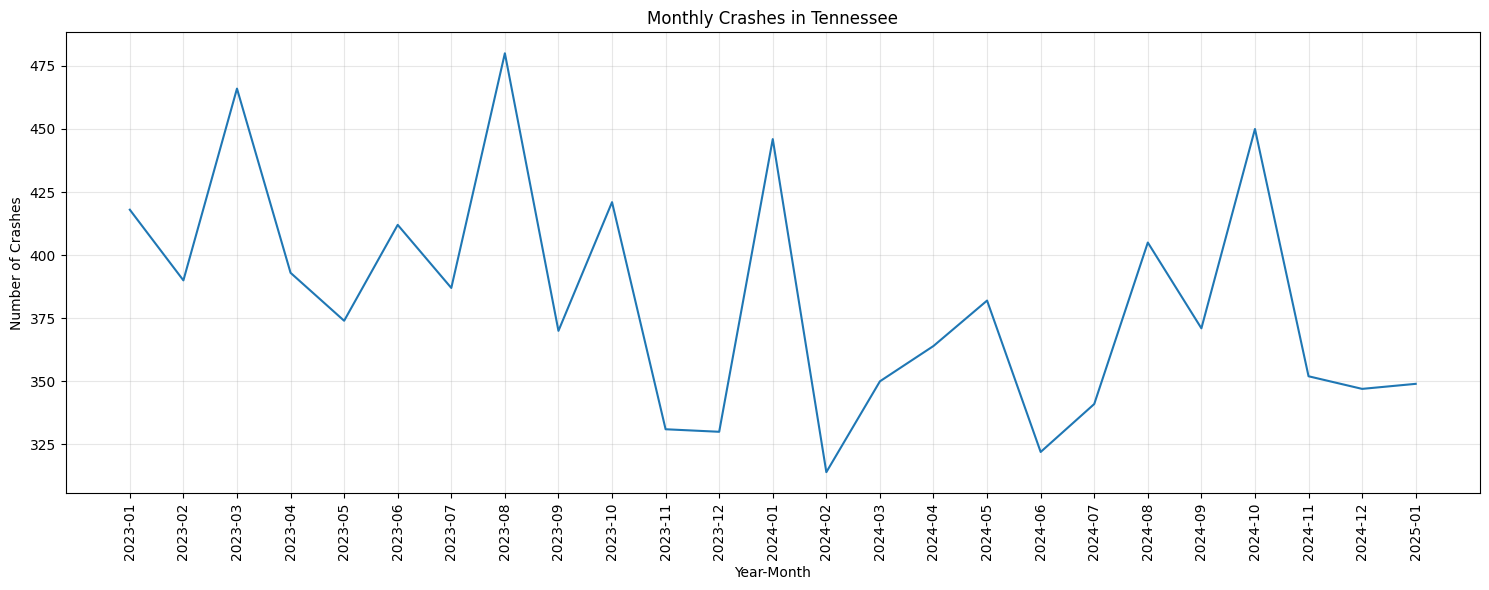

In [0]:
# Plot TN monthly crashes
plt.figure(figsize=(15, 6))
plt.plot(tn_monthly_pd['year_month'], tn_monthly_pd['total_crashes'])
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Number of Crashes')
plt.title('Monthly Crashes in Tennessee')
plt.grid(True, alpha=0.3)
plt.tight_layout()

It looks like there is some sort of seasonal pattern, but the peaks and troughs of the graph do not occur at regular interval of time. 

In [0]:
tn_county_data = monthly_county_counts.filter(col("Report State") == "TN")

# Keep county code in the grouping to allow individual county plotting
tn_monthly_crashes = tn_county_data.groupBy(
    col("Crash Year").alias("year"), 
    col("Crash Month").alias("month"),
    col("County Code").alias("county_code")  # Keep county code in the grouping
).agg(
    sum("crash_count").alias("total_crashes")
).orderBy("year", "month", "county_code")

# Convert to pandas for easier analysis and plotting
tn_monthly_pd = tn_monthly_crashes.toPandas()

# Create year-month string for x-axis
tn_monthly_pd['year_month'] = tn_monthly_pd['year'].astype(str) + '-' + tn_monthly_pd['month'].astype(str).str.zfill(2)

print(f"Total records for Tennessee: {tn_monthly_pd.shape[0]}")
print("\nSample of monthly crash data for Tennessee by county:")

Total records for Tennessee: 1694

Sample of monthly crash data for Tennessee by county:


In [0]:
import numpy as np

In [0]:
tn_monthly_pd[tn_monthly_pd['county_code'] == '47']

,year,month,county_code,total_crashes,year_month
1676,2025,1,47,5,2025-01


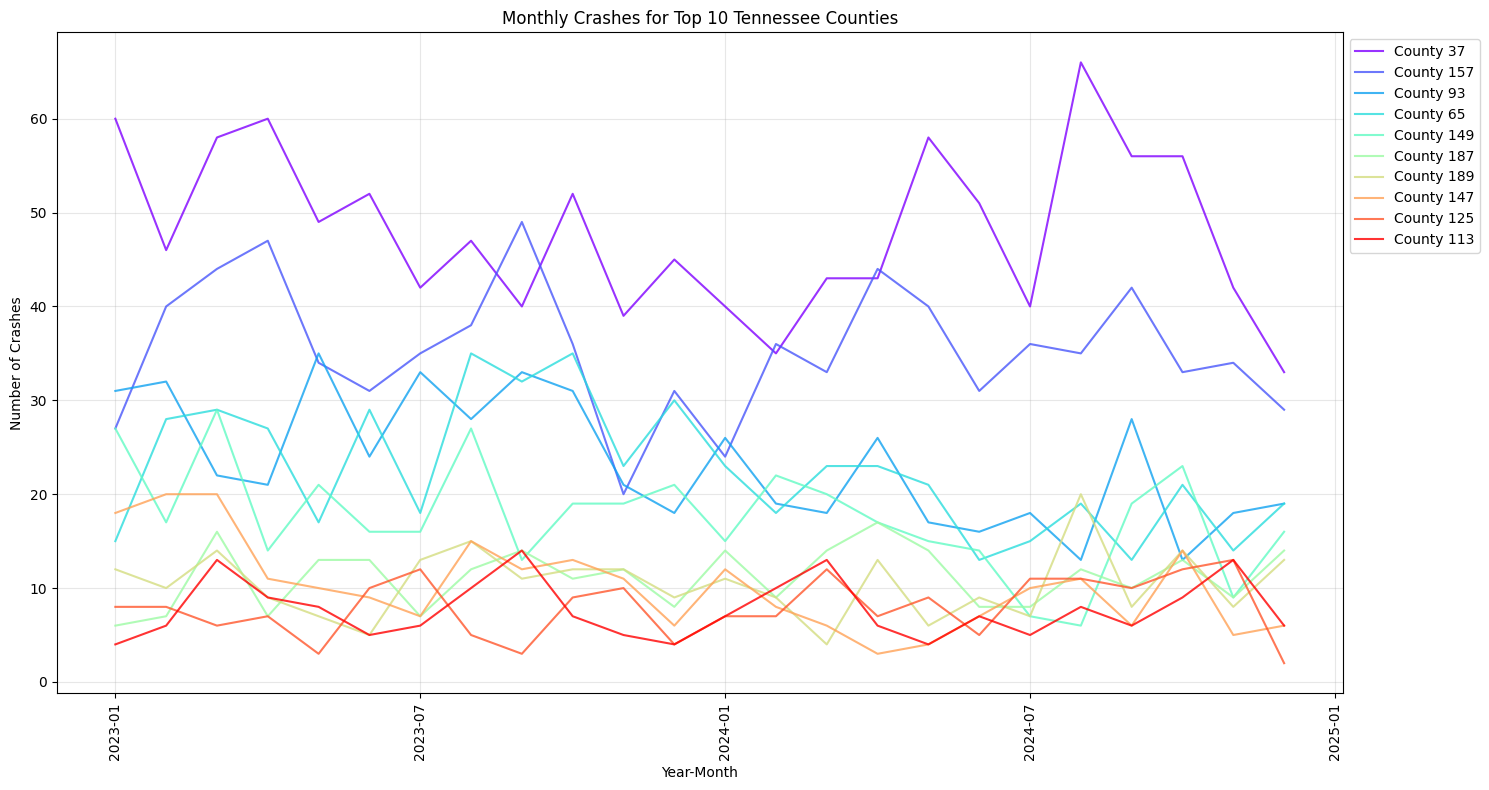

In [0]:
# Calculate total crashes per county to find top 10
county_totals = tn_monthly_pd.groupby('county_code')['total_crashes'].sum().reset_index()
top_counties = county_totals.sort_values('total_crashes', ascending=False).head(10)['county_code'].values

# Filter data to only include top 10 counties
top_county_data = tn_monthly_pd[tn_monthly_pd['county_code'].isin(top_counties)]


# Plot TN monthly crashes for top 10 counties only
plt.figure(figsize=(15, 8))

# Create a colormap with colors for top counties
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(top_counties)))

# Create empty lists for legend
lines = []
labels = []

# Plot each top county as a separate line
for i, county in enumerate(top_counties):
    county_data = top_county_data[top_county_data['county_code'] == county]
    
    # Sort by year_month to ensure proper line connection
    county_data = county_data.sort_values('year_month')
    
    # Get total crashes for this county for the legend
    total = county_totals[county_totals['county_code'] == county]['total_crashes'].values[0]
    
    # Plot the line
    line, = plt.plot(county_data['year_month'], county_data['total_crashes'], 
             color=colors[i], alpha=0.8, linewidth=1.5)
    
    # Add to legend with county code and total crashes
    lines.append(line)
    # Convert county to int

    labels.append(f"County {int(float(county))}")

# Show only a subset of x-ticks for readability
all_months = tn_monthly_pd['year_month'].unique()
plt.xticks(all_months[::6], rotation=90)  # Show every 6th month

plt.xlabel('Year-Month')
plt.ylabel('Number of Crashes')
plt.title('Monthly Crashes for Top 10 Tennessee Counties')
plt.grid(True, alpha=0.3)

# Add a legend with total crash counts
plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

There appear to be seasonal patterns in crash rates. For example, the purple line shows peaks around January 2023, mid-2023, early 2024, and a notable spike around August-September 2024. Some counties show relatively stable crash patterns while others display more volatility month-to-month. The highest county consistently experiencing 3-4 times more crashes than the counties at the bottom of the top 10 range.

In [0]:
spark.stop()